Fashion MNIST

In [1]:
!pip install wandb
import wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00


In [3]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [4]:
# !wandb login

In [5]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [6]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


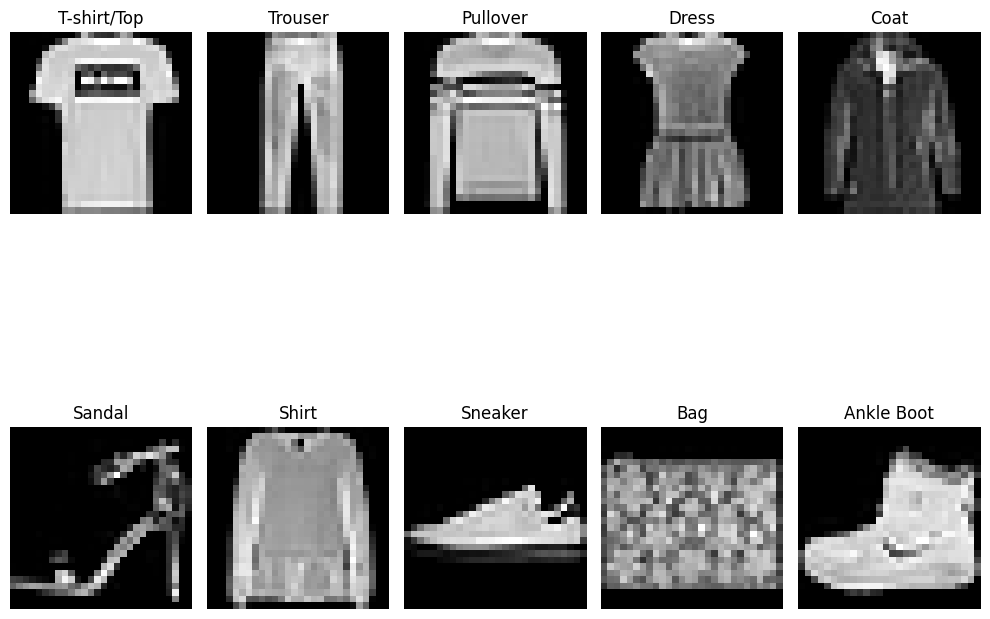

In [7]:
# this array keeps track for ind of each class
images_ind = []
# classes which are present
class_names = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

for i in range(10):
  for ind in range(X_train.shape[0]):
    if Y_train[ind] == i:
      images_ind.append(ind)
      break

# print(images_ind)

figure, axes = plt.subplots(2, 5, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
  ind = images_ind[i]
  ax.imshow(X_train[ind], cmap='gray')
  ax.axis('off')
  ax.set_title(class_names[i])

plt.tight_layout()
plt.show()  # Display the plot

In [107]:
def sigmoid(x):
    clip_x = np.clip(x, -500, 500)  # Clip x to avoid overflow
    return 1 / (1 + np.exp(-clip_x))

In [90]:
def Initialise(Layers, LayerWise, inputSize, outputSize):
  # need to initilaise the weights and basis
  W = [] # weights list
  B = [] # bias list
  preActivation = []
  activation = []

  LayerWise.insert(0, inputSize)
  for i in range(Layers):
    w = np.random.rand(LayerWise[i+1], LayerWise[i])
    b = np.random.rand(LayerWise[i+1])

    pa = np.zeros(LayerWise[i+1], dtype=np.float64)
    ac = np.zeros(LayerWise[i+1], dtype=np.float64)

    preActivation.append(pa)
    activation.append(ac)

    W.append(w)
    B.append(b)

  # for final layer

  return W, B, preActivation, activation

In [108]:
def feedForward(x, W, B, preActivation, activation):
  # we need to predict the output for the x
  n = len(W)
  x = x.flatten()

  y = x
  for i in range(n):
    preActivation[i] = np.dot(W[i], y) + B[i]
    activation[i] = sigmoid(preActivation[i])
    y = activation[i]


  # in the last layer we wont do the activation
  # we just need the sumation W^T.X + B of the last layer
  y = preActivation[n-1]
  e_x = np.exp(y)
  y = e_x / e_x.sum()

  return y

In [109]:
# layers = 4
# nodes  = [128, 128, 64, 10]
# inputSize  = 28*28
# outputSize = 10
# W, B, preActivation, activation  = Initialise(layers, nodes, inputSize, outputSize)
# for i in range(10):
#   y = feedForward(X_train[0], W, B, preActivation, activation)
#   print(y)

In [110]:
def findLoss(W, B, preActivation, activation):
  loss = 0
  for i in range(X_train.shape[0]):
    y = feedForward(X_train[i], W, B, preActivation, activation)
    # y returns the vector of the probabilities
    loss = loss -1*math.log(y[Y_train[i]])

  return loss

In [111]:
def backWardPropogation(X, y_corr, W, preActivation, activation, y_prob):
  layers = len(preActivation)
  # layers are numberd from 0 ... n - 1
  # and n-1 is output layer
  dw = [] # weight updations
  db = [] # bias updations
  da_l = y_prob
  da_l[y_corr] -= 1
  # dA_L is derivative of the last layer(output) of loss with dA
  layer = layers-1

  da = da_l
  dh = da_l
  while layer >= 0:
    dwk = np.outer(da, activation[layer-1], out=None)
    if layer == 0:
      dwk = np.outer(da, X, out=None)
    dbk = da

    if layer != 0:
      dh = np.dot(W[layer].T, da)
      dg = preActivation[layer-1]**2 - preActivation[layer-1]
      da = dh * dg

    dw.append(dwk)
    db.append(dbk)

    layer -= 1

  # we are appending derivatives in the reverse direction
  dw.reverse()
  db.reverse()


  return dw,db

In [124]:
def gradient_decent(epochs, learningRate):
  layers = 4
  nodes  = [128, 128, 64, 10]
  inputSize  = 28*28
  outputSize = 10
  W, B, preActivation, activation  = Initialise(layers, nodes, inputSize, outputSize)
  iteration = 0

  print(findLoss(W, B, preActivation, activation))

  while(iteration < epochs):
    dW = [np.zeros(array.shape) for array in W]
    dB = [np.zeros(array.shape) for array in B]

    for i in range(X_train.shape[0]):
      y = feedForward(X_train[i], W, B, preActivation, activation)
      # these are the partial derivates for one point
      dw, db = backWardPropogation(X_train[i], Y_train[i], W, preActivation, activation, y)

      # we need to update this for every point
      for i in range(len(dw)):
        dW[i] = dW[i] + dw[i]
        dB[i] = dB[i] + db[i]


    # updating weights and baises
    for i in range(len(dw)):
        W[i] = W[i] - learningRate*dw[i]
        B[i] = B[i] - learningRate*db[i]


    iteration += 1

    print(findLoss(W, B, preActivation, activation))



In [125]:
gradient_decent(4, 0.001)

262132.05754202578
219791.17213686238
345170.83633471583
345279.6273645376


<ipython-input-111-d3c865fe69b0>:23: RuntimeWarning: overflow encountered in multiply
  da = dh * dg
<ipython-input-124-ac858b104c03>:22: RuntimeWarning: invalid value encountered in add
  dW[i] = dW[i] + dw[i]
<ipython-input-124-ac858b104c03>:23: RuntimeWarning: invalid value encountered in add
  dB[i] = dB[i] + db[i]


nan


In [119]:
learningRate = 3
x = [np.array([1]), np.array([[3,4],[4,5]]), np.array([4,5,6])]
y = [np.array([1]), np.array([[3,4],[4,5]]), np.array([4,5,6])]

for i in range(len(x)):
  x[i] = x[i] + y[i]*learningRate

In [120]:
x

[array([4]),
 array([[12, 16],
        [16, 20]]),
 array([16, 20, 24])]